In [3]:
# 模拟类
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
import random
# import PyGeopack
import scipy as sp
from scipy import constants as C
from scipy.constants import physical_constants as PC
from scipy import stats as st
from scipy.special import erf
import math
import os
# import scienceplots
# import PyGeopack as gp
import copy
from functools import partial
from scipy.integrate import solve_ivp

class prt_sim(object):
    q = C.elementary_charge  # proton charge /Cb
    mu = C.proton_mass  # proton mass /kg
    Re = 0.6371E7  # one Earth Radius /m
    c = C.speed_of_light  # speed of light /m/s
    tilt = 0 # dipole axis tilt angle in degree

    def __init__(self, input_parameters, pulse_parameters, background_parameters):
        input_parameters = copy.deepcopy(input_parameters)
        pulse_parameters = copy.deepcopy(pulse_parameters)
        background_parameters = copy.deepcopy(background_parameters)
        
        self.input_parameters = input_parameters
        self.background_parameters = background_parameters
        self.pulse_parameters = pulse_parameters 
        self.m0, self.qabs, self.Mr, self.VDmag, self.param = self.get_basicquantity() # 质量，电荷，磁矩, 漂移速度参数
        self.Es, self.rs, self.phis, self.ts = [], [], [], []
    @property
    def input_parameters(self):
        return self._input_parameters

    @input_parameters.setter
    def input_parameters(self, value):
        if not isinstance(value, dict):
            raise TypeError("input parameters have to be dict type")
        
        allowed_keys = ["xmu", 'kp', 'raddist0', 'longi0', 'KEc0', 'pa',
                        'timedir', 'Tout', 'Dmin', 'pulse_flag', 'tmax', 'model', 'date']
        # 电荷正负，地磁扰动指数kp，粒子初始L值，经度，粒子初始动能，模拟时间步长，结果输出
        # 时间，最小距离步长，脉冲电场指示，最大模拟时间, 磁场模型, 日期（磁场模型中使用）

        for key in value.keys():
            if key not in allowed_keys:
                raise ValueError(f'key "{key}" is not allowed') 
            
        self._input_parameters = value

    @property
    def background_parameters(self):
        return self._background_parameters
    
    @background_parameters.setter
    def background_parameters(self, value):
        if not isinstance(value, dict):
            raise TypeError("pulse parameters have to be dict type")
        
        allowed_keys = ['phi0', 'E0', 'omega', 'guass_flag', 'random_phi_flag', 'Lambda']
        # 初始相位， 电场幅度，频率， 幅度是否满足沿L值的guass分布， 随机相位flag
        for key in value.keys():
            if key not in allowed_keys:
                raise ValueError(f'key "{key}" is not allowed') 
            
        self._background_parameters = value

    @property
    def pulse_parameters(self):
        return self._pulse_parameters

    @pulse_parameters.setter
    def pulse_parameters(self, value):
        if not isinstance(value, dict):
            raise TypeError("pulse parameters have to be dict type")
        
        allowed_keys = ['phi0', 'E0', 'c0', 'c1', 'c2', 'c3', 'p', 'va', 'ri', 'ti', 'di', 'rd', 'vpulse']
        for key in value.keys():
            if key not in allowed_keys:
                raise ValueError(f'key "{key}" is not allowed') 
            
        self._pulse_parameters = value


    def get_basicquantity(self):
        if self.input_parameters.get("xmu") == -1: # 电子
            m0 = C.electron_mass # 质量
            qabs = np.abs(C.elementary_charge) # 电荷
            self.q = -self.q
        elif self.input_parameters.get("xmu") == 1: # 质子
            m0 = C.proton_mass
            qabs = np.abs(C.elementary_charge)
        pa = self.input_parameters.get("pa") # 投掷角
        KEc0 = self.input_parameters.get("KEc0") # 粒子能量
        longi0 = self.input_parameters.get("longi0") # 初始位置经度
        raddist0 = self.input_parameters.get("raddist0") # 初始L值
        tilt = self.tilt
        Lambda = self.background_parameters.get("Lambda")
        # 初始位置转换为直角坐标系下（MAG)
        xc0 = raddist0 * np.cos(np.deg2rad(longi0))
        yc0 = raddist0 * np.sin(np.deg2rad(longi0))
        zc0 = 0 # 只考虑磁赤道电子
        mlt0 = np.mod(np.rad2deg(math.atan2(-1 * yc0, -1 * xc0)/15)+24, 24) # 初始磁地方时
        KEc0joule = KEc0 * 1000 * qabs  # energy in Joule
        
        # Calculating magnetic filed at position ptc0=(xc0, yc0, zc0)
        pulse_flag = self.input_parameters.get("pulse_flag")
        B = self.MAG(tilt, xc0, yc0, zc0) # magnetic field using inferred model in GSM coordinates /nT
        Ew1, Bu1 = self.pulse_fields(pulse_flag, 0, xc0, yc0, zc0) # pulse E field and pertubated B field  /V*m-1, T
        # Ew1_a, Bu1_a = pulse_fields_v0()
        B_tot = B + Bu1 * 1E9 # / nT
        Bt = np.linalg.norm(B_tot) # 总磁场，包含背景模型磁场          
        KEc0joule = KEc0 * 1000 * qabs  # energy in Joule
        Wtotjoule = KEc0joule + m0 * self.c ** 2
        # particle momnetum, from: W**2 = (P*C)**2 + (m0*c**2)**2
        ptotal2 = (Wtotjoule**2 - (m0 * self.c**2)**2) / self.c**2
        pperp2 = ptotal2 * (np.sin(np.deg2rad(pa)))**2
        # relativistic energy factor, gamma = (KE + m0*c**2)/(m0*c**2)
        gamma = (KEc0joule + m0 * self.c**2)/(m0 * self.c**2)
        # first adiabatic invariant eV/nT
        Mr = pperp2 / (2 * m0 * Bt * qabs) # magnetic moment
        param = self.get_param(Mr)
        betasquare = 1 - 1 / (gamma**2)
        VD = 3.5e-2 * 2 * np.pi / 360 * self.Re * raddist0**2 * betasquare * gamma
        VDmag = VD / raddist0 ** (1-Lambda) 
        if Lambda == -1 :
            VDmag = VD / raddist0 ** (1-param) 
        return m0, qabs, Mr, VDmag, param
    
    def prt_sim(self): # 一个粒子的模拟
        KEc0 = self.input_parameters.get("KEc0") # 粒子能量
        longi0 = self.input_parameters.get("longi0") # 初始位置经度
        raddist0 = self.input_parameters.get("raddist0") # 初始L值
        pa = self.input_parameters.get("pa") # 投掷角

        # if self.input_parameters.get("xmu") == -1: # 电子
        #     m0 = C.electron_mass # 质量
        #     qabs = np.abs(C.elementary_charge) # 电荷
        # elif self.input_parameters.get("xmu") == 1: # 质子
        #     m0 = C.proton_mass
        #     qabs = np.abs(C.elementary_charge)

        m0 = self.m0
        qabs = self.qabs
        kp = self.input_parameters.get("kp")
        tmax = self.input_parameters.get("tmax") # 最长模拟时长
        tilt = self.tilt

        # 初始位置转换为直角坐标系下（MAG)
        xc0 = raddist0 * np.cos(np.deg2rad(longi0))
        yc0 = raddist0 * np.sin(np.deg2rad(longi0))
        zc0 = 0 # 只考虑磁赤道电子
        # mlt0 = np.mod(np.rad2deg(math.atan2(-1 * yc0, -1 * xc0)/15)+24, 24) # 初始磁地方时
        # KEc0joule = KEc0 * 1000 * qabs  # energy in Joule
        
        # # Calculating magnetic filed at position ptc0=(xc0, yc0, zc0)
        # pulse_flag = self.input_parameters.get("pulse_flag")
        # B = self.MAG(tilt, xc0, yc0, zc0) # magnetic field using inferred model in GSM coordinates /nT
        # Ew1, Bu1 = self.pulse_fields(pulse_flag, 0, xc0, yc0, zc0) # pulse E field and pertubated B field  /V*m-1, T
        # # Ew1_a, Bu1_a = pulse_fields_v0()

        # B_tot = B + Bu1 * 1E9 # / nT
        # Bt = np.linalg.norm(B_tot) # 总磁场，包含背景模型磁场  

        # # ptc0: position-vector of initial gyrocenter, GSM coordinates
        ptc0 = np.array([xc0, yc0, zc0])
        # # total energy = kinetic energy + rest energy
        # Wtotjoule = KEc0joule + m0 * self.c ** 2
        # # particle momnetum, from: W**2 = (P*C)**2 + (m0*c**2)**2
        # ptotal2 = (Wtotjoule**2 - (m0 * self.c**2)**2) / self.c**2
        # pperp2 = ptotal2 * (np.sin(np.deg2rad(pa)))**2
        # # relativistic energy factor, gamma = (KE + m0*c**2)/(m0*c**2)
        # gamma = (KEc0joule + m0 * self.c**2)/(m0 * self.c**2)
        # # first adiabatic invariant eV/nT
        # Mr = pperp2 / (2 * m0 * Bt * qabs)

        rgc_o = ptc0 * self.Re # intial position in meters
        # VD_o = self.DERIV(0, rgc_o)
        # VDmag = np.linalg.norm(VD_o) # 漂移速度大小
        t0 = 0
        t_span = [t0, tmax]
        event_func1 = lambda t, r:self.event_function1(t,r)
        event_func1.terminal=True
        event_func1.direction=0
        event_func2 = lambda t, r:self.event_function2(t,r)
        event_func2.terminal=True
        event_func2.direction=0
        event_funcs = [event_func1, event_func2]
        # sol = solve_ivp(self.DERIV, t_span, rgc_o, method='RK45', t_eval=np.linspace(t0, tmax, 10000), events=event_funcs)
        sol = solve_ivp(self.DERIV, t_span, ptc0, method='Radau', t_eval=np.linspace(t0, tmax, 1000), events=event_funcs)
        return sol

    def event_function1(self, t, r):
        return np.linalg.norm(r) - 10  # 模拟最远到10Re
    
    def event_function2(self, t, r):
        return np.linalg.norm(r) - 2 # 模拟最近到2Re

    def MAG(self, tilt, x, y, z):
        # 默认gsm坐标系下偶极场
        #  待添加其他模型
        PS = np.deg2rad(tilt)
        SPS = np.sin(PS)
        CPS = np.cos(PS)
        PSI = PS
        M = 1
        P = x ** 2
        U = z ** 2
        V = 3 * z * x
        T = y ** 2
        Q = 0.7 * 0.31E5 / np.sqrt(P + T + U) ** 5
        Bx = Q * ((T + U - 2 * P) * SPS - V * CPS)
        By = -3 * y * Q * (x * SPS + z * CPS)
        Bz = Q * ((P + T - 2 * U) * CPS - V * SPS)
        # Bx = 0
        # By = 0
        # Bz = 0.311 * (np.sqrt(x**2 + y**2))**(-3) * 1e5
        return np.array([Bx, By, Bz])
    
    def pulse_fields(self, pulse_flag, t, x, y, z):
        # pulse fields calculate
        # input pulse_flag(=0,1,2), t(sec), x,y,z(Re)
        # return Epulse[3] (V/m), Bpulse[3] (Tesla)

        rv = np.float32(np.array([x, y, z]))
        Epulse = np.zeros_like(rv)
        Bpulse = np.zeros_like(rv)
        if pulse_flag == 0:
            return Epulse, Bpulse

        elif pulse_flag == 1:
            phi0 = self.pulse_parameters.get("phi0")
            E0 = self.pulse_parameters.get("E0")
            c0 = self.pulse_parameters.get("c0")
            c1 = self.pulse_parameters.get("c1")
            c2 = self.pulse_parameters.get("c2")
            c3 = self.pulse_parameters.get("c3")
            p = self.pulse_parameters.get("p")
            va = self.pulse_parameters.get("va")
            ri = self.pulse_parameters.get("ri")
            ti = self.pulse_parameters.get("ti")
            di = self.pulse_parameters.get("di")
            rd = self.pulse_parameters.get("rd") 
            vpulse = self.pulse_parameters.get("vpulse")
        else:
            raise TypeError(r"pulse flag must be 0 or 1")
        pulse_temp = {
            "phi0": phi0,
            "E0": E0,
            "c0": c0,
            "c1": c1,
            "c2": c2,
            "c3": c3,
            "p": p,
            "va": va,
            "ri": ri,
            "ti": ti,
            "di": di,
            "rd": rd,
            'vpulse':vpulse
        }       
        # calculate the unit vectors in spherical coord at r = (x, y, z):

        er, eu, ew = self.UNIT_Sph(rv)
        # get the local time of position rv = (x,y z)
        phi = np.mod(np.rad2deg(np.arctan2(y, x)) + 360, 360)

        # radial distance from center of Earth
        r = np.sqrt(x**2 + y**2 + z ** 2) * self.Re  # m
        EFw = self.Ephi(t, r, phi, pulse_temp)
        BFu = self.Btheta(t, r, phi, pulse_temp)
        BFr = self.Brad(t, r, phi, pulse_temp)

        Bu = np.zeros_like(rv)
        Br = np.zeros_like(rv)

        
        Epulse[0], Epulse[1], Epulse[2] = -EFw * ew[0], -EFw * ew[1], -EFw * ew[2]
        Bu[0], Bu[1], Bu[2] = -BFu * eu[0], -BFu * eu[1], -BFu * eu[2]
        Br[0], Br[1], Br[2] = -BFr * er[0], -BFr * er[1], -BFr * er[2]
        Bpulse = Bu + Br       
             
        return Epulse, Bpulse

    def Ephi(self, t, r, phi, pulse_temp):
        # input t:time-sec, r:rad.dist-m, phi:loctime-degrees
        # pulse_temp:phi0, E0, c0, c1, c2, c3, p, va, ri, ti, di, rd
        # return EFw

        # vr = self.vpulse(r)
        vr = pulse_temp.get("vpulse")
        phi0 = pulse_temp.get("phi0")
        phis = (phi - phi0) * 1.745329E-2
        E0 = pulse_temp.get("E0")
        c0 = pulse_temp.get("c0")
        c1 = pulse_temp.get("c1")
        c2 = pulse_temp.get("c2")
        c3 = pulse_temp.get("c3")
        p = pulse_temp.get("p")
        rd = pulse_temp.get("rd")
        va = pulse_temp.get("va")
        ri = pulse_temp.get("ri")
        ti = pulse_temp.get("ti")
        di = pulse_temp.get("di")
        t0 = (c3 * self.Re/va) * (1 - np.cos(phis))
        iexp = (r - ri + vr * (t-t0-ti))/di

        rexp = (r - ri - c0*vr*(t-t0-ti)- rd*self.Re) / di 
        E0ampl = E0 * 1E-3 * (1 + c1 * np.cos(phis))**p # V/m, E0 in mV/m; electric field emplitude with respect to phis and parameter p
        EFw = E0ampl * (np.exp(-iexp**2) - c2 * np.exp(-rexp**2))  # in V/m
        return EFw

    def Btheta(self, t, r, phi, pulse_temp):
        # input t:time-sec, r:raddist-m phi:loctime-degrees
        # pulse_temp:phi0, E0, c0, c1, c2, c3, p, va, ri, ti, di, rd
        # return Bfu(T)
        vr = pulse_temp.get("vpulse")
        phi0 = pulse_temp.get("phi0")
        phis = (phi - phi0) * 1.745329E-2
        E0 = pulse_temp.get("E0")
        c0 = pulse_temp.get("c0")
        c1 = pulse_temp.get("c1")
        c2 = pulse_temp.get("c2")
        c3 = pulse_temp.get("c3")
        p = pulse_temp.get("p")
        rd = pulse_temp.get("rd")
        va = pulse_temp.get("va")
        ri = pulse_temp.get("ri")
        ti = pulse_temp.get("ti")
        di = pulse_temp.get("di")
        t0 = (c3 * self.Re/va) * (1 - np.cos(phis))
        iexp = (r - ri + vr * (t-t0-ti))/di
        rexp = (r - ri - c0*vr*(t-t0-ti)-rd*self.Re) / di

        E0ampl = E0 * 1E-3 * (1 + c1 * np.cos(phis))**p # 
        dE0ampl = E0 * 1E-3 * p * (1 + c1 * np.cos(phis))**(p-1) # partial differentiation with respect to phis

        dvr = 0 # dv/dr, vpulse=const in this case
        Bu1_in_a = np.exp(-iexp**2)*(1+dvr*(t-t0-ti))/vr
        Bu1_in_b = -(di*np.sqrt(np.pi)*dvr/(2*vr**2))

        Bu1_re_a = np.exp(-rexp**2)*(-1.0+dvr*(t-t0-ti))/vr
        Bu1_re_b = (di*np.sqrt(np.pi)*dvr/(2*c0*vr**2))*(-1+erf(rexp))

        Bu1 = E0ampl * ( (Bu1_in_a + Bu1_in_b) - c2*(Bu1_re_a + Bu1_re_b) )

        Bu2_in = ( 1+erf(iexp))/(2*r*vr)
        Bu2_re = (-1+erf(rexp))/(2*r*vr)

        Bu2 = E0ampl*di*np.sqrt(np.pi)*(Bu2_in+(c2/c0)*Bu2_re)

        BFu = Bu1+Bu2
        return BFu

    def Brad(self, t, r, phi, pulse_temp):
        # 待补充
        vr = pulse_temp.get("vpulse")
        phi0 = pulse_temp.get("phi0")
        phis = (phi - phi0) * 1.745329E-2
        E0 = pulse_temp.get("E0")
        c0 = pulse_temp.get("c0")
        c1 = pulse_temp.get("c1")
        c2 = pulse_temp.get("c2")
        c3 = pulse_temp.get("c3")
        p = pulse_temp.get("p")
        rd = pulse_temp.get("rd")
        va = pulse_temp.get("va")
        ri = pulse_temp.get("ri")
        ti = pulse_temp.get("ti")
        di = pulse_temp.get("di")
        t0 = (c3 * self.Re/va) * (1 - np.cos(phis))
        iexp = (r - ri + vr * (t-t0-ti))/di
        rexp = (r - ri - c0*vr*(t-t0-ti)-rd*self.Re) / di

        E0ampl = E0 * 1E-3 * (1 + c1 * np.cos(phis))**p # 
        Br_in = E0ampl*di*np.sqrt(np.pi)*( 1+erf(iexp))/(2*r*vr)
        Br_re = (c2/c0)*E0ampl*di*np.sqrt(np.pi)*(-1+erf(rexp))/(2*r*vr)

        urad = np.arcsin(1)	# equatorial plane: theta = 90 deg

        BFr = -(1/np.arctan(urad))*(Br_in + Br_re)

        return BFr

    def vpulse(self, r):
        vpulse = 1e6 # m/s
        return vpulse
    
    def DERIV(self, xt, rgc):
        # relativistic 0th-order electic-force drift and 1st order gradient-B drift velocities
        # input: xt (time, in seconds), rgc (gyrocenter, in meters)
        # return: VD[3](guiding center velocity, in meters/sec)
        m0 = self.m0 # mass
        qabs = self.qabs # charge
        Mr = self.Mr # magnetic momemnt

        rgcRe = rgc # gyrocenter position in m, rgcRe in Re
        xgcRe = rgcRe[0]
        ygcRe = rgcRe[1]
        zgcRe = rgcRe[2]
        tilt = self.tilt

        # unit vectors in rgc:
        e1, e2, e3 = self.UNITEX(rgcRe, tilt)


        # define step-size ds: used in subs perpgradB, bdelb, bdotdelB
        ds = 1E-4  # Re

        # magnetic field calculations at rgc:
        B = self.MAG(tilt, xgcRe, ygcRe, zgcRe)

        pulse_flag = self.input_parameters.get("pulse_flag")
        Epw, Bpu = self.pulse_fields(pulse_flag, xt, xgcRe, ygcRe, zgcRe)  # pulse_fields()
        Epw_a, Bpu_a = np.zeros(3), np.zeros(3)  # pulse_fields_a()
        B_tot = B + Bpu * 1e9 + Bpu_a * 1e9 # nt
        Bt = np.linalg.norm((B_tot))
        Bt1 = 1 / Bt

        # new perpendicular relativistic particle momentum
        pperp2 = 2 * m0 * Bt * Mr * qabs
        # for 90 degree pitch angle particle, pperp2 = ptotl2
        ptotl2 = pperp2
        # New total particle energy in joules(kinetic + rest)
        Wtotjoule = np.sqrt(ptotl2 * self.c**2 + (m0 * self.c**2)**2)

        Wtot = Wtotjoule
        w_kinetic = Wtot/C.elementary_charge/1e6-0.511

        # new gamma
        gamma = (Wtotjoule) / (m0 * self.c**2)
        # gamma1 = 1 / gamma

        # gradient of unperturbed magnetic field
        pgrB = self.perpgradB(rgcRe, ds, tilt)  # pgrB in nt/Re
        e1_x_pgrB = np.cross(e1,pgrB) # E cross gradB
        # vfact = Mr * Bt1 * gamma1 * Re1 * 1E9 * q / qabs
        # Vg = VMULT(e1_x_pgrB, vfact)
        betasquare = 1 - 1 / (gamma**2)
        L = np.sqrt(xgcRe**2 + ygcRe**2)
        e1_x_pgrB_unit = np.multiply(e1_x_pgrB, 1 / np.linalg.norm(e1_x_pgrB))
        vfact = 3.5e-2 * 2 * np.pi / 360 * self.Re * L**2 * betasquare * gamma
        Vg = np.multiply(e1_x_pgrB_unit, vfact)

        # Background electric field calculations:

        Exgc, Eygc, Ezgc = self.EfieldBackground(xt, xgcRe, ygcRe, zgcRe)
        # 0th order electric drift E x B / B**2
        Egc = np.zeros(3)
        Egc[0], Egc[1], Egc[2] = Exgc + Epw[0], Eygc + Epw[1], Ezgc + Epw[2]
        E_x_e1 = np.cross(Egc, e1)
        Vf = np.zeros(3)
        Vf[0], Vf[1], Vf[2] = E_x_e1[0] * Bt1 * 1E9, E_x_e1[1] * Bt1 * 1E9, E_x_e1[2] * Bt1 * 1E9
        # total drift velocity Vd = Vf + Vg
        VD = np.add(Vf, Vg) / self.Re
        # print(np.linalg.norm(Vg))
        return VD

    def EfieldBackground(self, xt, x, y, z):
        allowed_keys = ['phi0', 'E0', 'omega', 'guass_flag', 'random_phi_flag']
        phi0 = self.background_parameters.get("phi0")
        E0 = self.background_parameters.get("E0") * 1e-3 # V/m
        omega = self.background_parameters.get("omega")
        guass_flag = self.background_parameters.get("guass_flag")
        random_phi_flag = self.background_parameters.get("random_phi_flag")
        raddist0 = self.input_parameters.get("raddist0")
        Lambda = self.background_parameters.get("Lambda")
        param = self.param
        raddist = np.sqrt(x**2 + y**2 + z**2)
        theta = math.atan2(y, x)
        if Lambda == -1:
            # Lambda = (np.log(((-param-2)*(raddist0**(-2)-raddist**(-2)))/(2 * raddist0**param * (raddist**(-param-2)-raddist0**(-param-2)))))/(np.log(raddist/raddist0))
            Lambda = (np.log(((-param-2)*(raddist0**(-2)-raddist**(-2)))/(2 * (raddist**(-param-2)-raddist0**(-param-2)))))/(np.log(raddist))
            if np.isnan(Lambda) or Lambda >1 or Lambda<0:
                raddist_ = raddist * 1.001
                # Lambda = (np.log(((-param-2)*(raddist0**(-2)-raddist_**(-2)))/(2 * raddist0**param * (raddist_**(-param-2)-raddist0**(-param-2)))))/(np.log(raddist_/raddist0))
                Lambda = (np.log(((-param-2)*(raddist0**(-2)-raddist_**(-2)))/(2 * (raddist_**(-param-2)-raddist0**(-param-2)))))/(np.log(raddist_))
        if omega == 0 :
            omega = self.VDmag/self.Re * raddist ** (-Lambda)
        E =  E0 * np.sin(omega * xt +  theta + phi0)
        self.Es.append(E)
        self.ts.append(xt)
        self.phis.append(np.mod(np.rad2deg(omega * xt +  theta + phi0), 360))
        self.rs.append(raddist)
        Ex = E * np.sin(theta)
        Ey = - E * np.cos(theta)
        Ez = 0
        return Ex, Ey, Ez
    
    def UNIT_Sph(self, r):
        # calculate unit vector in spherical coord at position r=(x,y,z)
        # return er, eu, ew
        # er: radial unit vector
        # eu: longitute unit vector
        # ew: latitude unit vector
        er = np.zeros_like(r)
        eu = np.zeros_like(r)
        ew = np.zeros_like(r)

        x, y, z = r[0], r[1], r[2]
        rxy = np.sqrt(x**2 + y**2)
        rxy1 = 1 / rxy
        rxyz = np.sqrt(x**2 + y**2 + z**2)
        rxyz1 = 1 / rxyz
        
        er[0], er[1], er[2] = x * rxyz1, y * rxyz1, z*rxyz1     # er[0] = sin(u) * cos(w), er[1] = sin(u) * sin(w), er[2] = cos(u)
        
        eu[0], eu[1], eu[2] = z * rxyz1 * x * \
            rxy1, z * rxyz1 * y * rxy1, -rxy * rxyz1         # eu[0] = cos[u] * cos(w), eu[1] = cos(u) * sin(w), eu[2] = -sin(u)
        ew[0], ew[1], ew[2] = -y * rxy1, x * rxy1, 0         # ew[0] = -sin(w), ew[1] = cos(w), ew[2] = 0

        return er, eu, ew

    def UNITEX(self, r, tilt):
        # Calculates unit vectors at position r=r(x,y,z)
        #   e1   : direction of mag. fd. (DIPOLE + EXTERNAL FIELD IN UNITEX)
        #   e2   : unit vector in the direction of (ephi)x(e1)
        #   e3   : unit vector in the direction of (e1)x(e2)
        #   er   : radial unit vector
        #   etheta: longitudional unit vector
        #   ephi : latitudional unit vector

        PS = np.deg2rad(tilt)
        
        x = r[0]
        y = r[1]
        z = r[2]

        e1 = np.zeros(3)
        e2 = np.zeros(3)
        e3 = np.zeros(3)

        er, etheta, ephi = self.UNIT_Sph(r)

        Bx, By, Bz = self.MAG(tilt, x, y, z)
        Bt = np.sqrt(Bx**2 + By**2 + Bz**2)

        # unit vector along field line
        e1[0] = Bx / Bt
        e1[1] = By / Bt
        e1[2] = Bz / Bt

        # unit vector in direction of (ephi x e1)
        ephxe1 = np.cross(ephi, e1)
        xmag = np.sqrt(np.dot(ephxe1, ephxe1))
        xmag1 = 1 / xmag
        e2[0] = ephxe1[0] * xmag1
        e2[1] = ephxe1[1] * xmag1
        e2[2] = ephxe1[2] * xmag1

        # unit vector inside plain defined by closed magnetic field line e3=(e1 x e2)
        e3 = np.cross(e1, e2)

        return e1, e2, e3
    
    def perpgradB(self, r, ds, tilt):
        # calculate the perpendicular gradient of the magnetic field at point r = r(x, y, z)

        dsRe = ds
        e1, e2, e3 = self.UNITEX(r, tilt)
        x1p = r[0] + dsRe * e2[0]
        y1p = r[1] + dsRe * e2[1]
        z1p = r[2] + dsRe * e2[2]
        x1m = r[0] - dsRe * e2[0]
        y1m = r[1] - dsRe * e2[1]
        z1m = r[2] - dsRe * e2[2]  # in Re

        x2p = r[0] + dsRe * e3[0]
        y2p = r[1] + dsRe * e3[1]
        z2p = r[2] + dsRe * e3[2]
        x2m = r[0] - dsRe * e3[0]
        y2m = r[1] - dsRe * e3[1]
        z2m = r[2] - dsRe * e3[2]  # in Re

        Bx, By, Bz = self.MAG(tilt, x1p, y1p, z1p)
        Bt1p = np.sqrt(Bx**2 + By**2 + Bz**2)

        Bx, By, Bz = self.MAG(tilt, x2p, y2p, z2p)
        Bt2p = np.sqrt(Bx**2 + By**2 + Bz**2)

        Bx, By, Bz = self.MAG(tilt, x1m, y1m, z1m)
        Bt1m = np.sqrt(Bx**2 + By**2 + Bz**2)

        Bx, By, Bz = self.MAG(tilt, x2m, y2m, z2m)
        Bt2m = np.sqrt(Bx**2 + By**2 + Bz**2)

        pgrB1 = (Bt1p - Bt1m) / (2 * ds)
        pgrB2 = (Bt2p - Bt2m) / (2 * ds)

        pgrB = np.zeros(3)
        pgrB[0] = pgrB1 * e2[0] + pgrB2 * e3[0]
        pgrB[1] = pgrB1 * e2[1] + pgrB2 * e3[1]
        pgrB[2] = pgrB1 * e2[2] + pgrB2 * e3[2]

        return pgrB
    
    def get_param(self, Mr):
        L = np.linspace(2, 10, 1000)
        coefs = list()
        mus = np.linspace(10, 16000, 1000) # MeV / 
        ws = 0.511 # rest energy /MeV
        for mu in mus:
            B = 0.311 * L ** (-3) # Guass
            # B = [np.linalg.norm(self.MAG(0, l, 0, 0)*1e-9) for l in L] # Guass
            gamma = np.sqrt(2 * mu * B / ws + 1)
            phi_dot = 3.5 * 1e-2 * L * (gamma - 1 / gamma) # angular velocity
            tau = 360 / phi_dot
            logL = np.log(L)
            logtau = np.log(tau)

            from scipy import optimize
            def f_1(x, k, b):
                return k * x + b

            k = optimize.curve_fit(f_1, logL, logtau)
            coef = k[0][0]
            coefs.append(coef)
        Mr = Mr * 1e-1
        index = np.argmin(np.abs(mus-Mr))
        param = coefs[index]
        return param

In [7]:
from prtsim3 import prt_sim
input_parameters = {
    "xmu": -1, # -1 for electron, 1 for proton
    "kp": 0, # = kp + 1
    "raddist0": 6, # initial L
    "longi0": 0, # intital phi
    'pa':90, # pitch angle
    "KEc0": 1000, # initial kinetic energy /KeV
    "timedir": 1,
    "Tout": 60,
    "Dmin": 0,
    "pulse_flag": 0, 
    "tmax": 10800, # maximum simulation time /s
}         

background_parameters = {
    "phi0" : np.pi/2,
    "E0" : 0.1, # mV/m
    "omega":0,
    "guass_flag":0,
    "random_phi_flag":0,
    "Lambda":0.4
}
p1 = prt_sim(input_parameters, {}, background_parameters)
sol = p1.prt_sim()

Text(0.5, 1.0, '$\\lambda=0.3$')

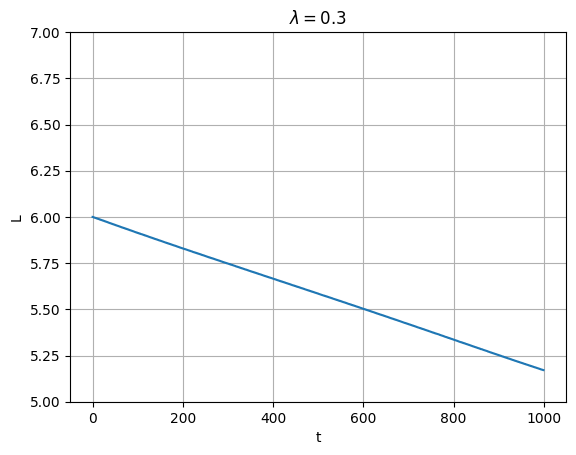

In [53]:
import itertools
# from prtsim3 import prt_sim
import numpy as np
import matplotlib.pyplot as plt
L0 = 6
Kecs = [2100]
# Es = np.arange(0.1, 1, 0.1)
Es = [0.1]
Lambdas = np.arange(0, 1.8, 0.05)
Lambdas = [0.3]
# longi0s = np.arange(0, 360, 20)
longi0s = [0]
tss = []
rss = []
phiss = []
Ess = []
for Kec,E, Lambda, longi0 in itertools.product(Kecs, Es, Lambdas, longi0s):
    input_parameters = {
        "xmu": -1, # -1 for electron, 1 for proton
        "kp": 0, # = kp + 1
        "raddist0": L0, # initial L
        "longi0": longi0, # intital phi
        'pa':90, # pitch angle
        "KEc0": Kec, # initial kinetic energy /KeV
        "timedir": 1,
        "Tout": 60,
        "Dmin": 0,
        "pulse_flag": 0, 
        "tmax": 10800, # maximum simulation time /s
    }         

    background_parameters = {
        "phi0" : np.pi/4,
        "E0" : 0.1, # mV/m
        "omega":0,
        "guass_flag":0,
        "random_phi_flag":0,
        "Lambda":Lambda
    }
    p1 = prt_sim(input_parameters, {}, background_parameters)
    sol = p1.prt_sim()
    # tss.append(p1.ts)
    # rss.append(p1.rs)
    # phiss.append(p1.phis)
    # Ess.append(p1.Es)
l = np.linalg.norm(sol.y, axis=0)
plt.plot(l)
plt.ylim(5,7)
plt.grid()
plt.xlabel('t')
plt.ylabel('L')
plt.title("$\lambda=0.3$")

(0.0, 0.0001)

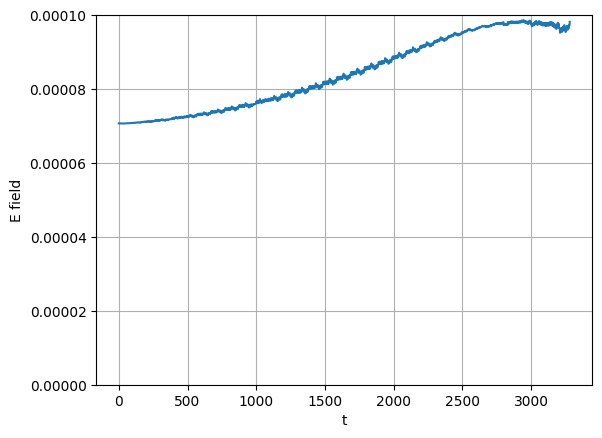

In [52]:
def smooth(target):
    window_size = 30
    # 计算移动平均
    result = np.convolve(target, np.ones(window_size)/window_size, mode='valid')
    return result
plt.plot(smooth(p1.Es))
plt.grid()
plt.xlabel('t')
plt.ylabel("E field")
plt.ylim(0, 1e-4)

C:\Users\tghyw\AppData\Local\Temp\ipykernel_22232\2897203401.py:480: RuntimeWarning: invalid value encountered in scalar divide
  Lambda = (np.log(((-param-2)*(raddist0**(-2)-raddist**(-2)))/(2 * (raddist**(-param-2)-raddist0**(-param-2)))))/(np.log(raddist))


Text(0.5, 1.0, '$\\lambda=-1$')

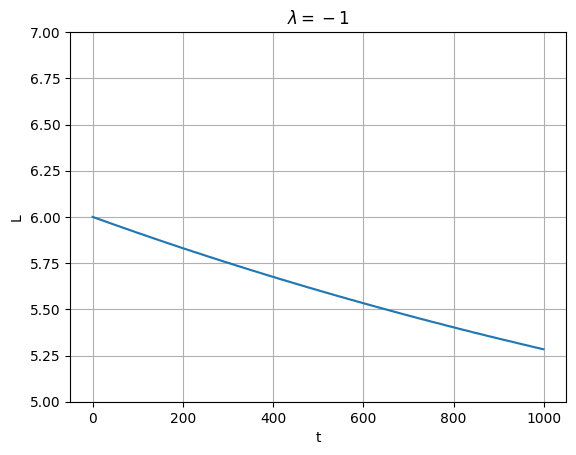

In [46]:
import itertools
# from prtsim3 import prt_sim
import numpy as np
import matplotlib.pyplot as plt
L0 = 6
Kecs = [2100]
# Es = np.arange(0.1, 1, 0.1)
Es = [0.1]
Lambdas = np.arange(0, 1.8, 0.05)
Lambdas = [-1]
# longi0s = np.arange(0, 360, 20)
longi0s = [0]
tss = []
rss = []
phiss = []
Ess = []
for Kec,E, Lambda, longi0 in itertools.product(Kecs, Es, Lambdas, longi0s):
    input_parameters = {
        "xmu": -1, # -1 for electron, 1 for proton
        "kp": 0, # = kp + 1
        "raddist0": L0, # initial L
        "longi0": longi0, # intital phi
        'pa':90, # pitch angle
        "KEc0": Kec, # initial kinetic energy /KeV
        "timedir": 1,
        "Tout": 60,
        "Dmin": 0,
        "pulse_flag": 0, 
        "tmax": 10800, # maximum simulation time /s
    }         

    background_parameters = {
        "phi0" : np.pi/4,
        "E0" : 0.1, # mV/m
        "omega":0,
        "guass_flag":0,
        "random_phi_flag":0,
        "Lambda":Lambda
    }
    p1 = prt_sim(input_parameters, {}, background_parameters)
    sol = p1.prt_sim()
    # tss.append(p1.ts)
    # rss.append(p1.rs)
    # phiss.append(p1.phis)
    # Ess.append(p1.Es)
l = np.linalg.norm(sol.y, axis=0)
plt.plot(l)
plt.ylim(5,7)
plt.grid()
plt.xlabel('t')
plt.ylabel('L')
plt.title("$\lambda=-1$")

(0.0, 0.0001)

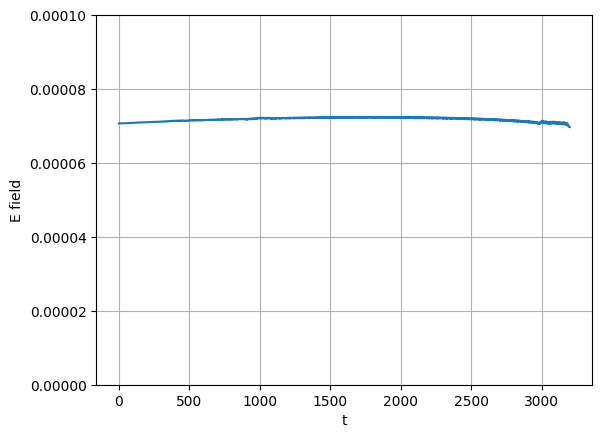

In [50]:
def smooth(target):
    window_size = 100
    # 计算移动平均
    result = np.convolve(target, np.ones(window_size)/window_size, mode='valid')
    return result
plt.plot(smooth(p1.Es))
plt.grid()
plt.xlabel('t')
plt.ylabel("E field")
plt.ylim(0, 1e-4)